In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [24]:
#Defining date range for historical analysis
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime(2022, 12, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)
#['2020-04-20']
CRUDE_NEGATIVE_PRICES_DATE = datetime(2020, 4, 20)

#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [25]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)

    #define the date crude oil prices went negative
    negative_price_date = pd.to_datetime("2020-04-20")

    # Remove the negative price date from floating storage dataset
    df_fs = df_fs[df_fs['date'] != negative_price_date]
    
    return df_fs

In [26]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2020-01-01,145,9016861
1,2020-01-02,139,8437023
2,2020-01-03,141,7750023
3,2020-01-04,134,7886513
4,2020-01-05,139,8568887
...,...,...,...
1091,2022-12-27,171,13097687
1092,2022-12-28,181,13298507
1093,2022-12-29,176,13862553
1094,2022-12-30,172,14031847


Text(0, 0.5, 'Floating Storage (t)')

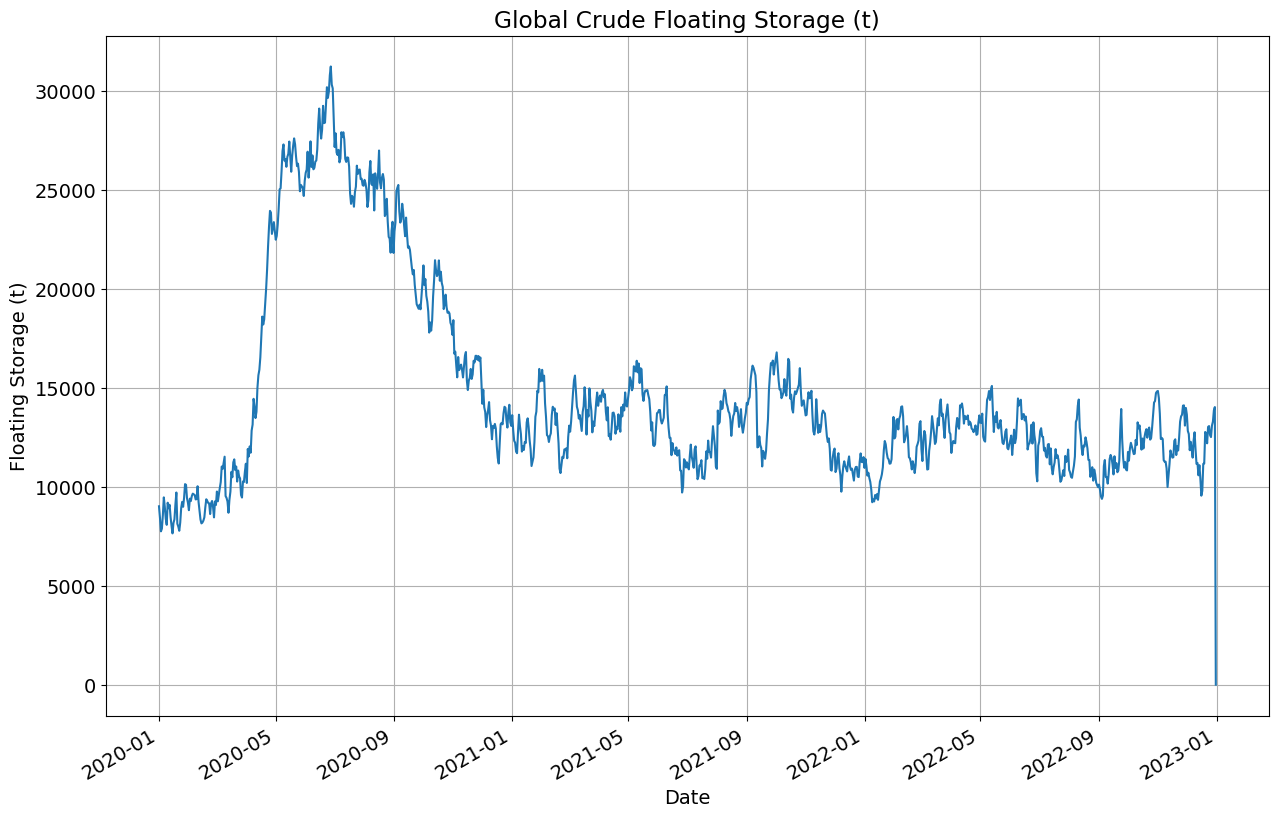

In [27]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

In [37]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
negative_price_date = spot_prices[spot_prices.iloc[:, 0] < 0].index
print(negative_price_date)
spot_prices = spot_prices.drop(negative_price_date)
spot_prices

DatetimeIndex(['2020-04-20'], dtype='datetime64[ns]', freq='D')


,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2020-01-01,61.14,67.77
2020-01-02,61.17,67.05
2020-01-03,63.00,69.08
2020-01-04,63.00,69.08
2020-01-05,63.00,69.08
...,...,...
2022-12-27,79.45,82.45
2022-12-28,78.89,81.70
2022-12-29,78.43,80.96
2022-12-30,80.16,82.82


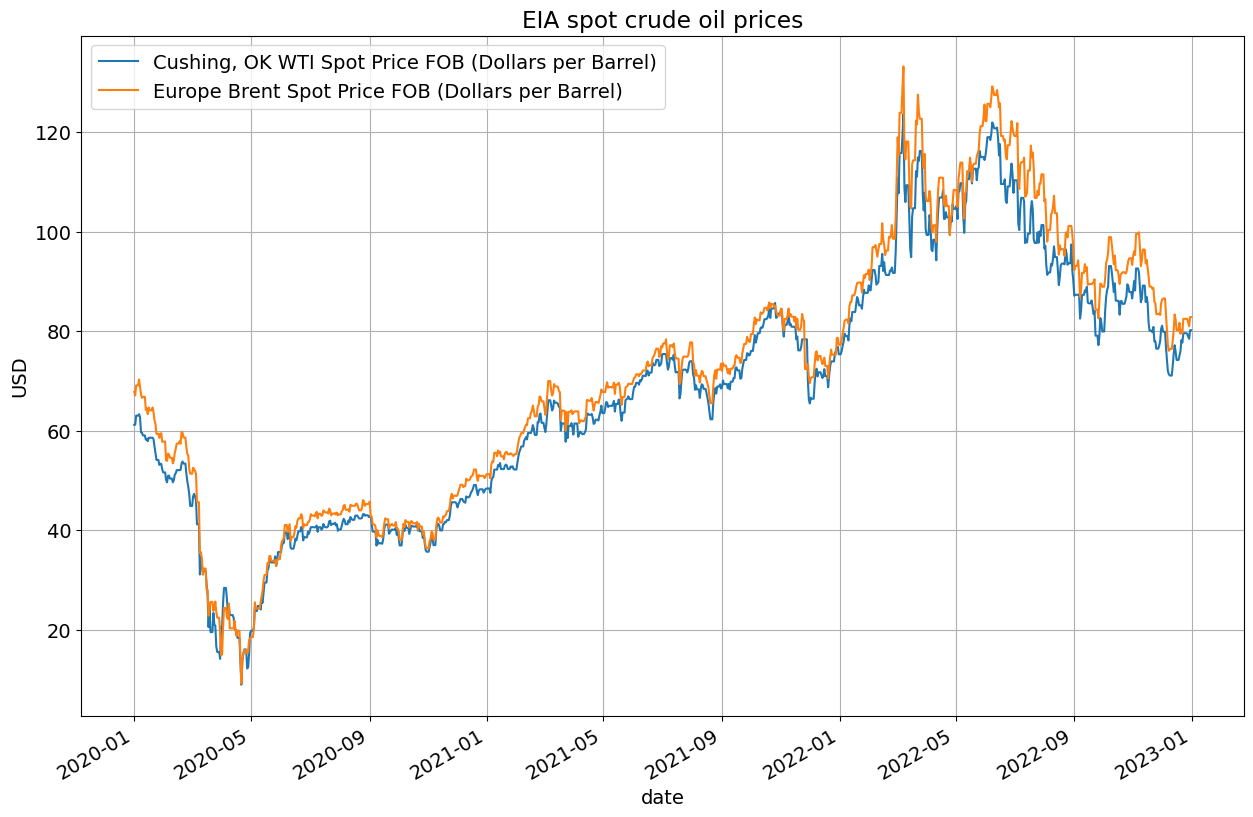

In [33]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#removed dates where crude oil prices are negative


In [38]:
spot_prices = spot_prices.iloc[:, 0]

In [42]:
future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
future_prices = future_prices.drop(negative_price_date)
future_prices
#removed date (20/04/2020) where spot crude oil prices were negative

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2020-01-01,61.06,60.77,60.41,59.97
2020-01-02,61.18,60.95,60.64,60.24
2020-01-03,63.05,62.82,62.48,62.02
2020-01-04,63.05,62.82,62.48,62.02
2020-01-05,63.05,62.82,62.48,62.02
...,...,...,...,...
2022-12-27,79.53,79.64,79.68,79.57
2022-12-28,78.96,79.08,79.13,79.05
2022-12-29,78.40,78.50,78.54,78.46
2022-12-30,80.26,80.45,80.53,80.45


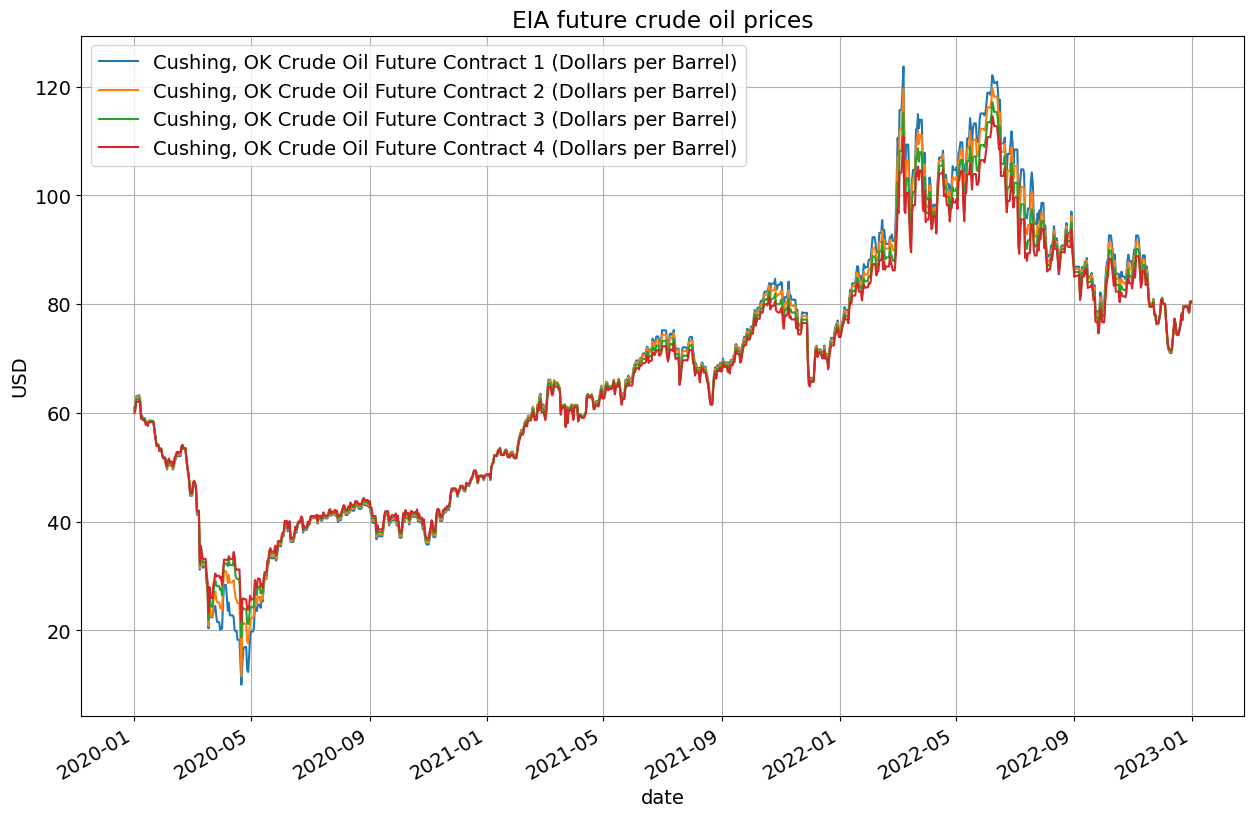

In [43]:
future_prices.plot(title='EIA future crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

In [44]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values
calendar_spread

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2020-01-01,-0.08,-0.37,-0.73,-1.17
2020-01-02,0.01,-0.22,-0.53,-0.93
2020-01-03,0.05,-0.18,-0.52,-0.98
2020-01-04,0.05,-0.18,-0.52,-0.98
2020-01-05,0.05,-0.18,-0.52,-0.98
...,...,...,...,...
2022-12-27,0.08,0.19,0.23,0.12
2022-12-28,0.07,0.19,0.24,0.16
2022-12-29,-0.03,0.07,0.11,0.03
2022-12-30,0.10,0.29,0.37,0.29


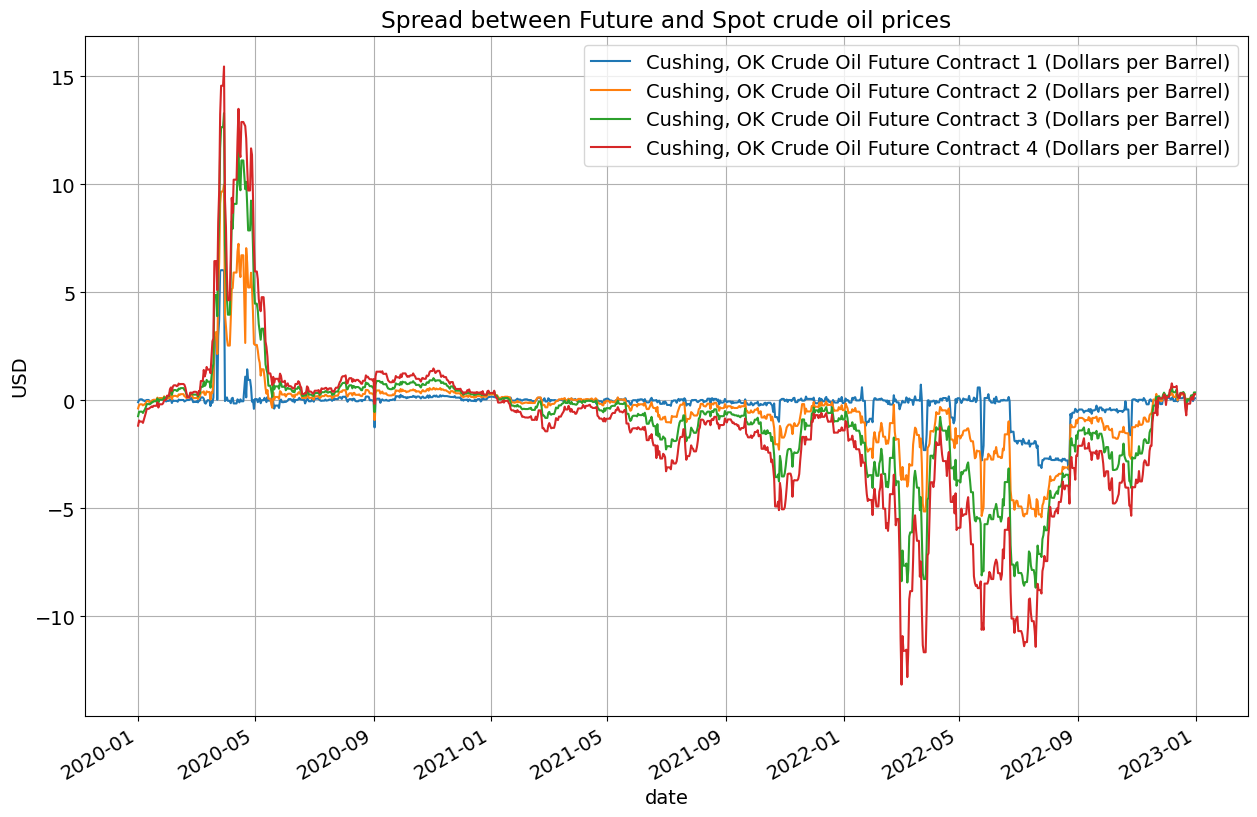

In [45]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

In [46]:
future_prices = future_prices.iloc[:, 3]
calendar_spread = calendar_spread.iloc[:, 3]

In [47]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

In [48]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

In [49]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.334985
1    0.342896
dtype: float64

In [50]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot(211)
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot(212)
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

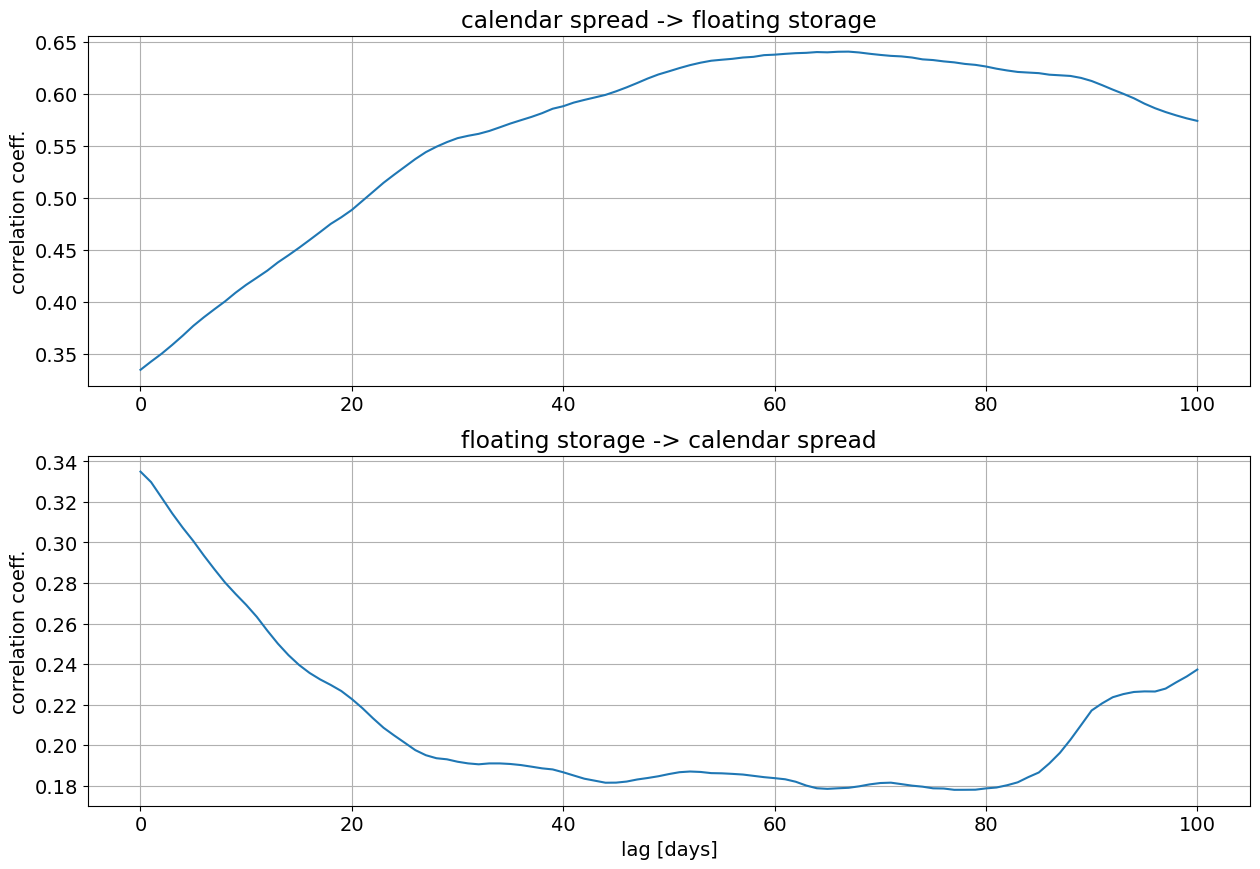

In [51]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

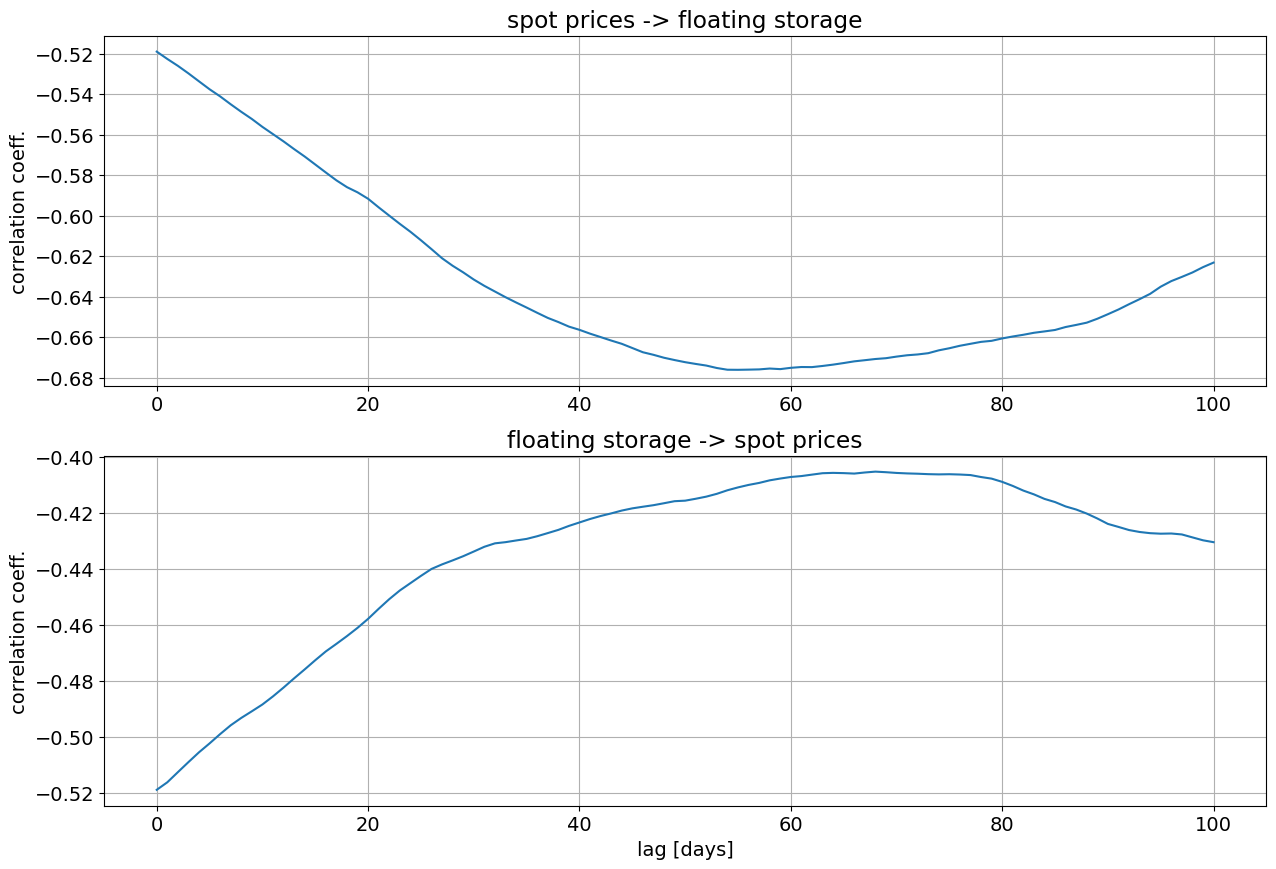

In [52]:
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

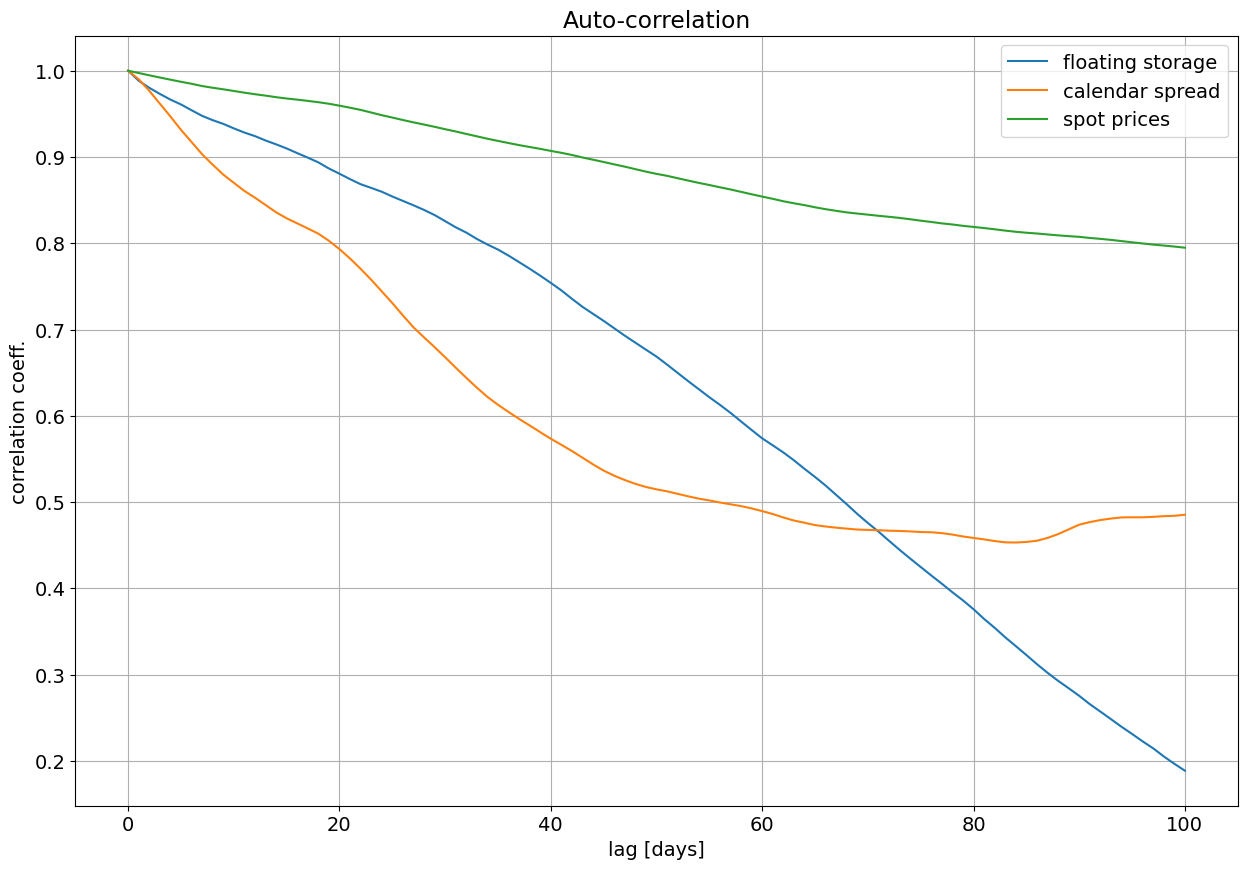

In [53]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

In [54]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6119  , p=0.0320  , df_denom=1091, df_num=1
ssr based chi2 test:   chi2=4.6246  , p=0.0315  , df=1
likelihood ratio test: chi2=4.6148  , p=0.0317  , df=1
parameter F test:         F=4.6119  , p=0.0320  , df_denom=1091, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3389  , p=0.0969  , df_denom=1088, df_num=2
ssr based chi2 test:   chi2=4.6993  , p=0.0954  , df=2
likelihood ratio test: chi2=4.6893  , p=0.0959  , df=2
parameter F test:         F=2.3389  , p=0.0969  , df_denom=1088, df_num=2


In [55]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot(211)
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot(212)
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')


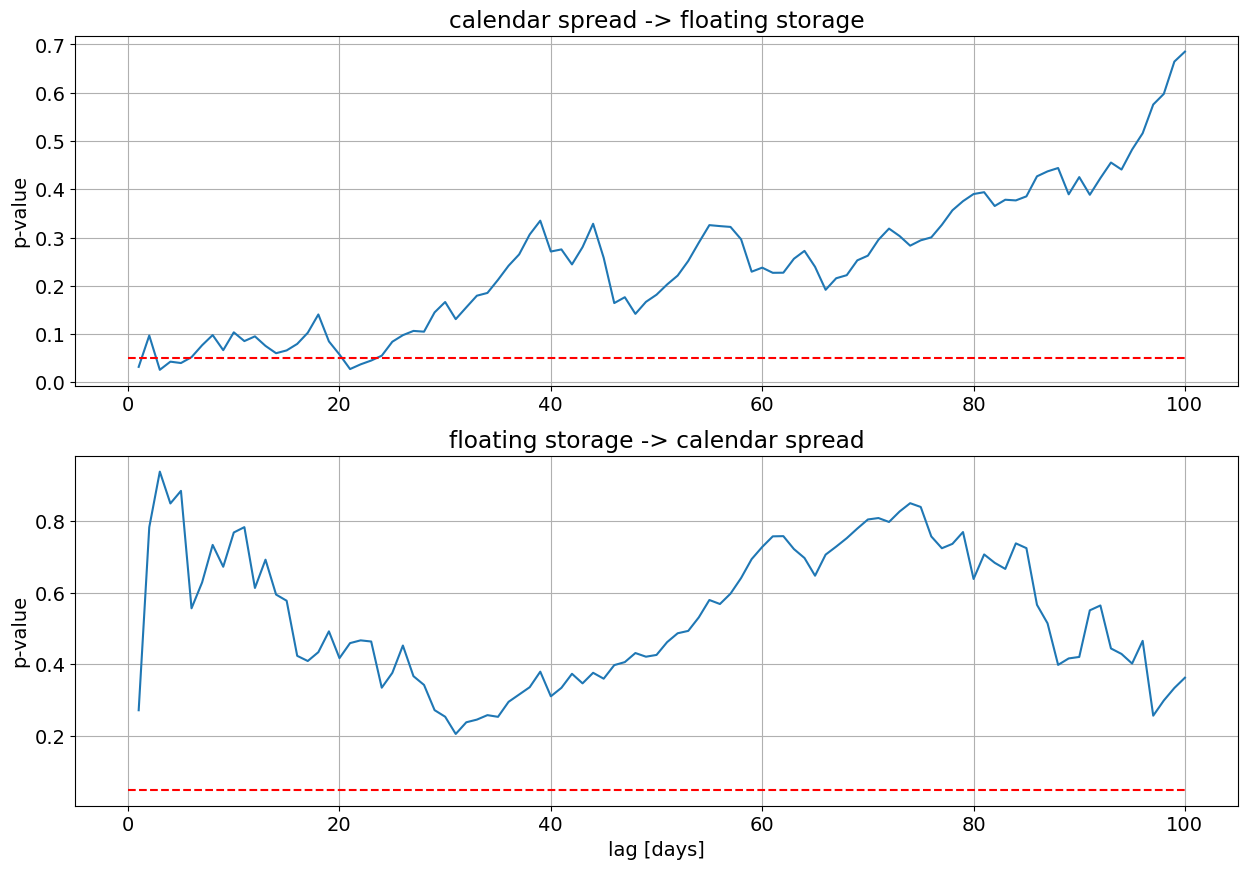

In [56]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

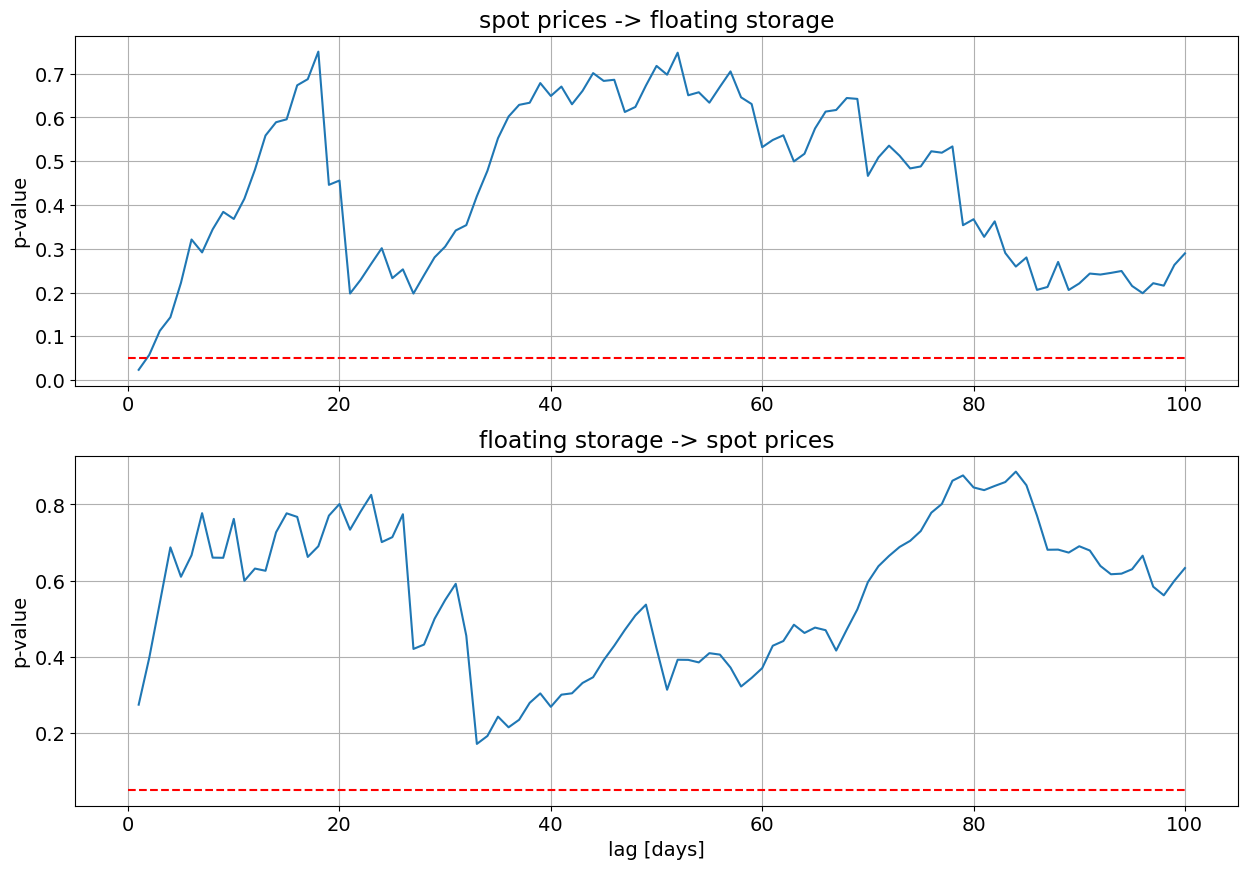

In [57]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

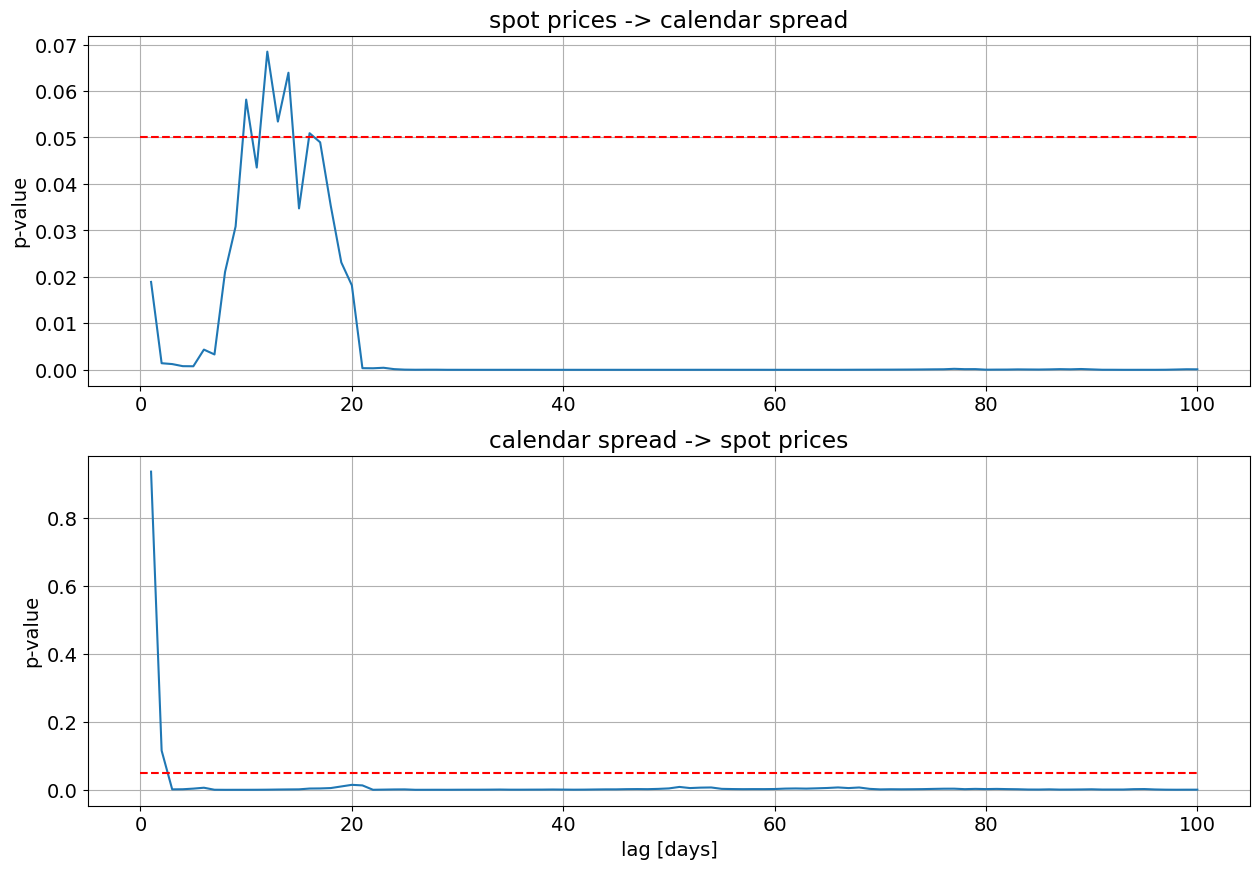

In [58]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')